# Introduction

This project will attempt to predict the 2023-2024 NBA regular season MVP, DPOY, Rookie of the Year, and Most Improved Player. The data to be used in this experiment has been obtained from https://www.basketball-reference.com, which provides in depth statistics for player per game statistical averages over the past 20 - 30 seasons. For the purposes of this investigation we will limit ourselves to 10 seasons.

It is important to note that this dataset was obtained on March the 13th, with the majority of the teams having played 65 or so matches of the 82. Therefore some of these averages are subject to change before the voting is complete, however for the purposes of this exercise we will assume them to be constant. Another aspect of MVP voting that cannot be accounted for are non-statistical elements, such as player narrative and popularity as these tend to affect voting as much as performance. For example, a player playing for one of 'Big Market' teams such as the Lakers, Celtics or the Heat will receive much more media attention than a player performing equally well for a small market team. Consequently, we will have to pretend we exist in a world where MVP voting is purely performance based. 

Now enough rambling. Let's get started. 



# Dataset

As previously mentioned, the dataset was obtained from https://www.basketball-reference.com. The dataset in question contains regular season per game averages for each player, in each of the last 10 seasons, all the way back to the 2013-2014 season. The dataset in question, intially obtained as a series of text files, has since been collated into a single Database File, just to have a centralised DB that can be queried for any required data. This dataset is stored locally on my desktop for now. 

The Database structure contains 5 tables as follows: All NBA Teams Player Data, MVP Player Data, DPOY Player Data and Rookie of the Year Player Data. 

See below for a glimpse into the appearance of the data:

In [1]:
# Importing neccessary modules to interact with the SQL DB and load it into a Pandas DataFrame 
import sqlite3
import pandas as pd 
import numpy as np

#Declaring a SQL Connection String - Note DB Browser for SQL Lite was used here to test queries and analyse Databases
conn = sqlite3.connect(r'C:\Users\conor\Documents\Python\NBA Player Awards\Player Data\NBA_Players.db')
All_Players_NBA = pd.read_sql('SELECT * FROM NBA_Player_Data', conn)
All_Players_NBA.sample(5)

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
6329,354,277,Jonathan Kuminga,PF,20,GSW,67,16,20.8,3.9,...,1.0,1.4,2.4,0.084,-1.7,-0.1,-1.7,0.1,2022-2023,0
6148,173,136,Kris Dunn,PG,28,UTA,22,3,25.8,5.3,...,1.3,0.6,1.9,0.162,0.7,1.7,2.4,0.6,2022-2023,0
3533,434,328,Frank Mason III,PG,24,SAC,38,0,11.4,1.9,...,0.0,0.3,0.3,0.033,-1.9,-1.3,-3.1,-0.1,2018-2019,0
5327,164,131,Dewayne Dedmon,C,32,MIA,67,15,15.9,2.4,...,1.5,2.0,3.5,0.157,-2.2,1.1,-1.0,0.3,2021-2022,0
3954,147,114,Robert Covington,C,29,HOU,22,21,33.0,4.0,...,0.2,1.2,1.4,0.094,-1.2,1.4,0.2,0.4,2019-2020,0


Some information on the above table. Each row (or sample) contains a mix of numeric, categorical and boolean columns (or features). Each feature, with the exception of *Season* and *Rookie Season*. Were obtained from Basketball Reference. 

Season was added to distinguish what season a players per game average relate to, as players will have multiple seasons with different averages. Rookie Season was added, so that a players roookie season could be identified, with 1 (True) meaning it is their rookie season, and False meaning not. This was added with the intention of using previous Rookie Seasons to potentially predict this seasons ROTY (i.e. Wembanyama), or even to just determine what a players stats were in their rookie season. 

See the attached text file **Feature Explanation** for an expanded view on what each column heading means, as there are a *lot* of features to work through here. 

# Choice of Model 

In order to decide what model we are using, and even more generally what form of ML we need we first need to understand what we're predicting and why. For any end of season award in the NBA, say the MVP a number of pundits, broadcasters and sports personalities all get to vote for their MVP. Each 'Judge' gets to choose 5 players from first to fifth, who are then allocated 10,7,5,3,1 points respectively. The player with the largest proportion of votes is then crowned the MVP. That must surely lead to people's own biases and grudges affecting their voting I hear you think, and you're right, but in this prediction the world is perfect and voting will be statistically based.
$$
    \text{Share}_{\text{Per Player}} = \frac{{\text{MVP Voting Points}}_{\text{Per Player}}}{\text{Total number of points if all judges ranked player first}}
$$

So, we can see we are trying to predict a number, **Share**. This is chosen rather than Total number of points, as this can change per year depending on the amount of judges. 

If we are trying to predict a number, we are using a regression model. The model I have chosen to use, is the Random Forest Model. This is mainly due to the ensemble nature of the model. Random Forests use a collection of individual Decision Trees (DT's) predictions, all averaged out to make their final decision. This will be useful here, as we will use a DT trained on each seasons MVP winners, to predict this seasons winner, and we will then get the most common Winners based on combined shares from each prediction. This will also be interesting, as it will show how different seasons winners, will then affect who they think should win this year. For example, will a Steph Curry MVP season favour a high scoring PG MVP? Or will a Giannis MVP favour Giannis again this year? Or perhaps favour a player playing with an output more similar to Giannis' championship year? Exciting times ahead. 


But first, see below from this experiments sponsor, the Random Forest Model:<br>
<br>
Random Forest is a popular ensemble learning method used for both classification and regression tasks. Here's a brief explanation of how it works and why it's a good choice for regression:<br>
<br>
**Decision Trees:** Random Forest is built upon the concept of decision trees. Decision trees are hierarchical structures composed of nodes that represent features or attributes, and branches that represent decisions based on those features. Each leaf node represents a prediction.<br>
<br>
**Ensemble Learning:** Random Forest combines multiple decision trees to form a more robust and accurate model. Instead of relying on the prediction of a single decision tree, it aggregates the predictions of many trees to make a final prediction. This process is known as ensemble learning. This was the appeal of using a Random Forest for this experiment, although in theory any model could be used and then aggregated, but what the flip let's live a little and go by the book.

**Randomness:** Random Forest introduces randomness in two key ways:<br>
**Bootstrap sampling:** Each tree in the Random Forest is trained on a bootstrap sample of the original dataset. Bootstrap sampling involves randomly selecting observations from the dataset with replacement. This results in each tree being trained on a slightly different subset of data, adding diversity to the ensemble.<br>

**Voting or averaging:** For regression tasks, the predictions of individual trees are typically aggregated by averaging. Each tree's prediction contributes equally to the final output, leading to a robust prediction that tends to be less sensitive to noise and outliers. This will make our final MVP vote a tad more robust than simply going off last years trends.

**Reduced Overfitting:** By aggregating predictions from multiple trees and introducing randomness, Random Forest tends to generalize well to unseen data and is less prone to overfitting compared to individual decision trees. Again, another advantage of using data from multiple years.

**Handles Non-linearity and Interaction:** Random Forest can capture non-linear relationships and interactions between features effectively, making it suitable for regression tasks where the relationship between predictors and response variables may not be linear. For example, a players Points per game doesn't result in a linear increase in attention. Once you average over 30 PPG the media interest increases massively. Or for example the difference between averaging a triple double and not can be simply a rebound, however the increase in attention (and consequently increase in MVP share) is enourmous.

In summary, Random Forest is a good choice for regression tasks because it leverages the power of ensemble learning to produce accurate predictions, handles non-linearity and interactions well, and is robust against overfitting. Its ability to introduce randomness ensures diversity among individual trees, leading to a more reliable model.

## Model Error 

In regression decision trees, the error in the training set is typically calculated using a metric called the mean squared error (MSE). The MSE measures the average squared difference between the actual values (targets) and the predicted values made by the decision tree model on the training data. 

For this experiment, the error will be judged on the MSE between actual MVP Share, and predicted MVP Share. 

# MVP Prediction

Firstly a look at last seasons winners

In [2]:
MVP_Shares = pd.read_sql('SELECT * FROM MVP_Player_Data', conn)
MVP_Shares.tail(13)

,index,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,...,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,-9999,Season
114,0,1,Joel Embiid,28,PHI,73.0,915.0,1000,0.915,66,...,4.2,1.0,1.7,0.548,0.330,0.857,12.3,0.259,embiijo01,2022-2023
115,1,2,Nikola Jokić,27,DEN,15.0,674.0,1000,0.674,69,...,9.8,1.3,0.7,0.632,0.383,0.822,14.9,0.308,jokicni01,2022-2023
116,2,3,Giannis Antetokounmpo,28,MIL,12.0,606.0,1000,0.606,63,...,5.7,0.8,0.8,0.553,0.275,0.645,8.6,0.204,antetgi01,2022-2023
117,3,4,Jayson Tatum,24,BOS,0.0,280.0,1000,0.280,74,...,4.6,1.1,0.7,0.466,0.350,0.854,10.5,0.185,tatumja01,2022-2023
118,4,5,Shai Gilgeous-Alexander,24,OKC,0.0,46.0,1000,0.046,68,...,5.5,1.6,1.0,0.510,0.345,0.905,11.4,0.226,gilgesh01,2022-2023
119,5,6,Donovan Mitchell,26,CLE,0.0,30.0,1000,0.030,68,...,4.4,1.5,0.4,0.484,0.386,0.867,8.9,0.176,mitchdo01,2022-2023
120,6,7,Domantas Sabonis,26,SAC,0.0,27.0,1000,0.027,79,...,7.3,0.8,0.5,0.615,0.373,0.742,12.6,0.221,sabondo01,2022-2023
121,7,8,Luka Dončić,23,DAL,0.0,10.0,1000,0.010,66,...,8.0,1.4,0.5,0.496,0.342,0.742,10.2,0.204,doncilu01,2022-2023
122,8,9,Stephen Curry,34,GSW,0.0,5.0,1000,0.005,56,...,6.3,0.9,0.4,0.493,0.427,0.915,7.8,0.192,curryst01,2022-2023
123,9,10,Jimmy Butler,33,MIA,0.0,3.0,1000,0.003,64,...,5.3,1.8,0.3,0.539,0.350,0.850,12.3,0.277,butleji01,2022-2023


As there are a lot of features, we need to try remove some from our model. Some features are more important than others, while some are just noise. This will also help generalise the model. It will also make the end model simpler. 

Firstly, we will append the share value of each player above to their Regular season averages from the initial table. We will then create a correlation matrix, to see what values impacted the share value most.

In [3]:
#Creating a list for the MVP List each Season, and the seasons
MVP_DF_List = []
Season_List = ['2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019','2019-2020','2020-2021','2021-2022','2022-2023']
#For each season, creating a list of Dataframes for the MVP Players each season
for i in Season_List:
    df = MVP_Shares[MVP_Shares['Season'] == i][['Player','Share']]
    MVP_DF_List.append(df)

In [4]:
All_Players_DF_List = []
#Similarly creating a list of the Players from each season
for i in Season_List:
    df = All_Players_NBA[All_Players_NBA['Season'] == i]
    All_Players_DF_List.append(df)

Note that the above method had to be used as some players (Lebron etc) appear in multiple MVP lists, so bulk assigning MVP shares would cause conflicts. So to hop, skip and jump our way over this, we split the data to per season, and then assign shares each season. Awesome Sauce. These lists of dataframes can be joined again, as they were created in the same ascending order using the *Season_List* list.

In [5]:
All_Players_Merged_List = []
#performing a left join of each seasons MVP share to their season stats. 
for i,j in zip(MVP_DF_List,All_Players_DF_List):
    df = pd.merge(j, i, on='Player', how='left')
    df = df.fillna(0)
    All_Players_Merged_List.append(df)
#This final list will now be concatenated to one master DataFrame

In [6]:
MVP_Master_DF = pd.concat(All_Players_Merged_List,ignore_index = True)
MVP_Master_DF['Share'].value_counts()

Share
0.000    6527
0.001      17
0.002       8
0.005       6
0.010       5
         ... 
0.731       1
0.205       1
0.075       1
0.932       1
0.280       1
Name: count, Length: 83, dtype: int64

Categorical and Boolean columns can be dropped already

In [7]:
MVP_Master_DF_EDA = MVP_Master_DF.drop(['index','Rk','Player','Pos','Age','Tm','Player-additional','Season','Rookie Season'],axis=1)
#These players are now just all numbers in the system, a cog in this extremely exciting machine

In [8]:
MVP_Master_DF_EDA.columns

Index(['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Share'],
      dtype='object')

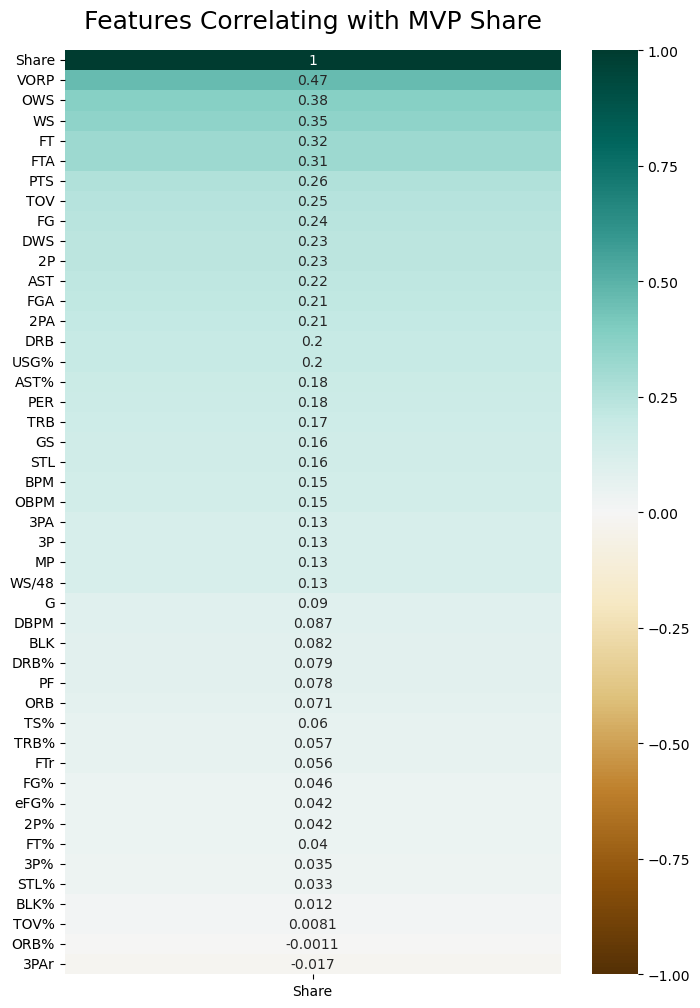

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(MVP_Master_DF_EDA.corr()[['Share']].sort_values(by='Share', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with MVP Share', fontdict={'fontsize':18}, pad=16);

Holy Smokes. The above is quite useful. Also fairly intuitive. Value over replacement player (VORP) is the most indicative advanced metric over the last 10 years of MVP. Which makes sense, as if you are much more valuable then an average player to your team you the real MVP (Seriously). Also interesting to note, that this is followed by Offensive Win Shares & Win Shares. The MVP is generally given to players with a serious offensive output, and this does show that. MVP players are also fouled a lot, so they do like the Free Throw line

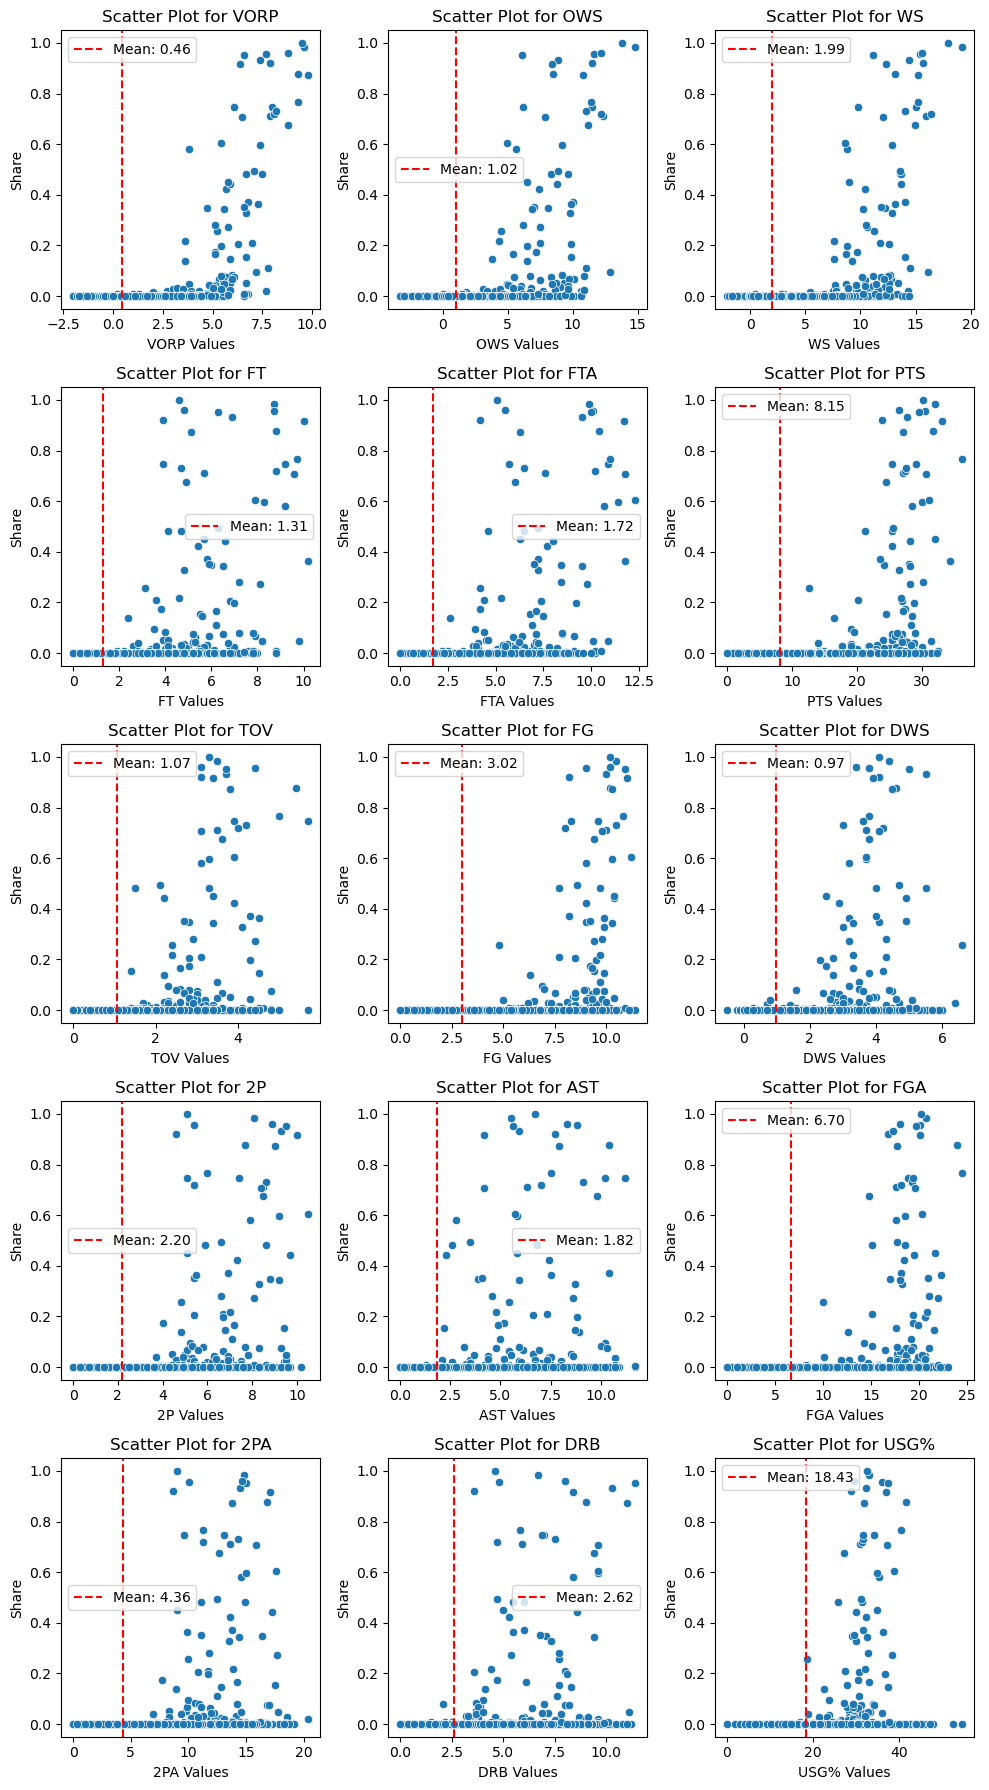

In [10]:
# List of columns to be plotted against Share
columns_to_plot = ['VORP', 'OWS','WS','FT','FTA','PTS','TOV','FG','DWS','2P','AST','FGA','2PA','DRB','USG%']

# Create a 5 by 3 grid
fig, axes = plt.subplots(5, 3, figsize=(10, 18))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through columns and plot on each axis
for i, column in enumerate(columns_to_plot):
    sns.scatterplot(data=MVP_Master_DF_EDA, x=column, y='Share', ax=axes[i])
    axes[i].set_xlabel(f'{column} Values')
    axes[i].set_ylabel('Share')
    axes[i].set_title(f'Scatter Plot for {column}')

    # Calculate mean of x-axis values
    x_mean = MVP_Master_DF[column].mean()
    
    # Add vertical line at x-axis mean
    axes[i].axvline(x_mean, color='r', linestyle='--', label=f'Mean: {x_mean:.2f}')
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


**VORP** It can be seen above that any legitimate MVP candidate doesn't have a VORP below 3. <bw>

**OWS, DWS, WS** Any MVP candidate has an OWS, DWS, & WS higher than ~4,1.5 & 7. MVP's would singlehandedly want to be able to influence the outcome of matches <bw> 

**USG%** We can also see that MVP candidates all have > 20% Usage. Strange to note that there seems to be a stop at about 45%. This could potentially indicate over usage I would think. In the sense that teams that don't have 2 or 3 valuable supporting cast type players will over use their best player. This tends to happen in small market teams, which generally don't have the narrative required (or league position) to warrant MVP votes for their star player.

**AST & %USG** There doesn't appear to be a massive correlation here for Assists per game. However upon looking at the scatter plot, the Usage% graph shows a clearer trend for high MVP Shares, even though Assists 

### Plan of Action (P.O.A)

OK. Right. So. Here we are now. All the lads. <bw>

So we've had enough EDA and fiddling around with our data. We now have a plan. We are going to: 

**1:** Reduce the training Dataset to only contain features that correlated $\geq$ 0.2 with MVP Share. 

**2:** Define a list of bounds for each of those features, based on the Scatter Plot Grid, to reduce the dataset even further and get rid of noise. This serves both the purpose of reducing noise, as well as statlines that are non MVP calibre affecting the final model. The final dataframe will then have the features normalised to avoid any feature dominating the prediction based on magnitude of the values alone 

Now for the Modelling: 

**3:** Split the remaining Data into 10 seasons. We are then going to train a Regression Decision Tree on each season. 

**4:** A smidgeon, sprinkling, and a dabble of Parameter tuning to then reduce the average MSE (Mean Squared Error) accross all seasons.

Now for the predicting. 

**5:** Finally, each trained Classifer will be then used to predict the current MVP on this seasons data. 

**6:** These votes will then be added together to get the top 10 predictions. 

**7:** Jokic will be the winner 

### 1 

In [11]:
MVP_Master_DF = MVP_Master_DF[['Player','Pos','Age','Tm','Season','Share','VORP', 'OWS','WS','FT','FTA','PTS','TOV','FG','DWS','2P','AST','FGA','2PA','DRB','USG%']]
MVP_Master_DF.sample(5)

,Player,Pos,Age,Tm,Season,Share,VORP,OWS,WS,FT,...,PTS,TOV,FG,DWS,2P,AST,FGA,2PA,DRB,USG%
3361,JaMychal Green,PF,28,LAC,2018-2019,0.0,0.1,0.5,1.1,0.7,...,8.7,1.0,3.3,0.6,1.9,0.6,6.8,3.5,5.2,17.6
4361,Ish Smith,PG,31,WAS,2019-2020,0.0,0.3,1.3,1.9,0.9,...,10.9,1.4,4.5,0.6,3.6,4.9,10.1,7.6,2.8,19.1
1652,Shabazz Muhammad,SF,23,MIN,2015-2016,0.0,-0.2,2.6,2.7,2.3,...,10.5,0.9,3.9,0.2,3.3,0.6,8.3,6.5,2.0,22.8
1979,Mike Dunleavy,SF,36,TOT,2016-2017,0.0,0.1,0.8,1.5,0.7,...,5.2,0.5,1.8,0.7,0.8,0.9,4.2,1.6,1.8,14.0
2429,Thaddeus Young,PF,28,IND,2016-2017,0.0,1.4,2.0,4.6,0.6,...,11.0,1.3,4.9,2.7,4.3,1.6,9.3,7.7,4.3,16.4


In [12]:
MVP_Master_DF.shape

(6654, 21)

### 2

In [13]:
#These limits will be defined based on the scatter grid, in a list of the form {Feature}_Limits = [min,max]
#These values were chosen to limit the data, as VORP was the most correlated, WS encompasses both  OWS & DWS (addition of both features), 
#and historically, no MVP other than Bill Russell averaged under about 15 points if I recall correctly
VORP_Limits = [0.8,15]
WS_Limits = [1.99,25]
PTS_Limits = [8,40]

In [14]:
#Assigning limits
MVP_Master_DF = MVP_Master_DF[(MVP_Master_DF['VORP'] > VORP_Limits[0]) & (MVP_Master_DF['VORP'] < VORP_Limits[1])]
MVP_Master_DF = MVP_Master_DF[(MVP_Master_DF['WS'] > WS_Limits[0]) & (MVP_Master_DF['WS'] < WS_Limits[1])]
MVP_Master_DF = MVP_Master_DF[(MVP_Master_DF['PTS'] > PTS_Limits[0]) & (MVP_Master_DF['PTS'] < PTS_Limits[1])]

In [15]:
#Checking the reduction
MVP_Master_DF.shape

(1220, 21)

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Subset of columns to normalize
columns_to_normalize = ['VORP', 'OWS','WS','FT','FTA','PTS','TOV','FG','DWS','2P','AST','FGA','2PA','DRB','USG%']

# Normalize the subset of columns
MVP_Master_DF[columns_to_normalize] = scaler.fit_transform(MVP_Master_DF[columns_to_normalize])

### 3 & 4

In [17]:
Per_Season = []
for i in Season_List:
    Per_Season.append(MVP_Master_DF[MVP_Master_DF['Season'] == i])

In [18]:
#importing all neccessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from statistics import mean 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib

#Defining a set of hyperparameters for the model. The optimum combination of these will be found using the Randomised SearchCV function
parameters = {
    'max_depth' :  (3,5,7,9,10),
    'min_samples_split' :  (2,4,6), 
    'splitter' : ('best', 'random'),
    'max_features' : ('sqrt','log2')
}

#Instantiating the DTC Classifier 
model = DecisionTreeRegressor(random_state=44)

#Here we invoke the RandomizedSearchCV function. Rather than iterate through every single possible combination of parameters, it randomly finds the best
#combination of a subset of the possible permutations. Using the above model and parameters, with 5 Fold Cross Validation and Verbose set to False.
#This is step 4 in the plan
DT_Grid = GridSearchCV(model, param_grid = parameters,cv = 5, verbose = False)

#Splitting the Dataframe into Numeric Training Variables, and Target variable to try predict
X = MVP_Master_DF[['VORP', 'OWS', 'WS','FT', 'FTA', 'PTS', 'TOV', 'FG', 'DWS', '2P', 'AST', 'FGA', '2PA','DRB', 'USG%']]
y = MVP_Master_DF['Share']

#Splitting the Training Data into a 80/20 Training Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

#After fitting the model, using the best_estimator_method to isolate the most accurate model, and assign it to the best_model variable
DT_Grid.fit(X_train, y_train)
best_model = DT_Grid.best_estimator_

# Save the trained model to a file
save_location = 'C:/Users/conor/Documents/Python/NBA Player Awards/MVP/Decision_Tree_Model_Total.pkl'
joblib.dump(best_model, save_location)

#Calculating the error 
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'The Mean Squared error for an Optimised DTC on all data (all season) simultaneously is : {round(mse,5)}')

The Mean Squared error for an Optimised DTC on all data (all season) simultaneously is : 0.00682


And now to try the same steps, on a season by season basis to see if creating multiple Decision Trees is more accurate

In [19]:


#Declaring a list for the MSE per season
mse_list = []
#Instantiating the Decision Tree Regressor model
model = DecisionTreeRegressor(random_state=44)

#Simulatneously iterating through the Season string, and data associated with that string
for i,j in zip(Per_Season,Season_List):
    #Optimising Hyperparameters for each season 
    DT_Grid = GridSearchCV(model, param_grid = parameters,cv = 5, verbose = False)
    #Splitting data into Training Columns and Target Variable
    X = i[['VORP', 'OWS', 'WS','FT', 'FTA', 'PTS', 'TOV', 'FG', 'DWS', '2P', 'AST', 'FGA', '2PA','DRB', 'USG%']]
    y = i['Share']
    #Splitting the data into Training/Test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
    #Fitting the model
    DT_Grid.fit(X_train, y_train)
    #Using the best_estimator_ atttribute of GridSearchCV to assign the best performing model to a variable
    best_model = DT_Grid.best_estimator_
    # Save the best performing model to a file
    save_location = 'C:/Users/conor/Documents/Python/NBA Player Awards/MVP/Decision_Tree_Model_' + j + '.pkl'
    joblib.dump(best_model, save_location)
    # Calculate MSE
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
print(f'The average MSE for on optimised DTC per season is : {round(mean(mse_list),5)}')

The average MSE for on optimised DTC per season is : 0.01578


We are still going to use this method to try predict this seasons MVP, as we want to see how each season predicts MVP. 

### 5

In [20]:
#Selecting this seasons player data from the SQL DB
Current_Season = pd.read_sql('SELECT * FROM NBA_Player_Data WHERE Season = "2023-2024"', conn)
Current_Season.sample(5)

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
137,137,105,Robert Covington,PF,33,LAC,3,3,23.0,1.0,...,0.1,0.1,0.2,0.125,-2.4,4.5,2.1,0.1,2023-2024,0
518,518,410,Immanuel Quickley,PG,24,TOR,29,29,33.5,6.2,...,1.3,0.5,1.8,0.090,1.4,-1.4,0.0,0.5,2023-2024,0
341,341,276,Jonathan Kuminga,PF,21,GSW,63,37,25.9,6.1,...,2.2,1.6,3.8,0.112,0.1,-0.4,-0.3,0.7,2023-2024,0
506,506,400,Micah Potter,PF,25,UTA,3,0,6.7,1.0,...,0.1,0.0,0.1,0.152,3.5,-1.3,2.2,0.0,2023-2024,0
587,587,469,Jaden Springer,PG,21,BOS,8,0,2.8,0.3,...,-0.1,0.0,0.0,-0.092,-11.7,-1.9,-13.6,-0.1,2023-2024,0


In [21]:
#Reducing the features to only the desired features
Current_Season_ = Current_Season[['Player','Pos','Age','Tm','Season','VORP', 'OWS','WS','FT','FTA','PTS','TOV','FG','DWS','2P','AST','FGA','2PA','DRB','USG%']]

# Subset of columns to normalize
columns_to_normalize = ['VORP', 'OWS','WS','FT','FTA','PTS','TOV','FG','DWS','2P','AST','FGA','2PA','DRB','USG%']

# Normalize the subset of columns
Normalised_Columns = scaler.fit_transform(Current_Season_[columns_to_normalize])
Current_Season_.loc[:,columns_to_normalize] = Normalised_Columns

In [22]:
#Declaring a Dictionary that will hold the MVP Predictions for each season. 
MVP_Predictions = {}

#Splitting the new Test Data into categorical and Numeric Data
Current_Season_Numeric = Current_Season_[['VORP', 'OWS','WS','FT','FTA','PTS','TOV','FG','DWS','2P','AST','FGA','2PA','DRB','USG%']]
Current_Season_Descriptive = Current_Season_[['Player','Pos','Age','Tm','Season']]

for i in Season_List:
    # Load the saved model from file
    model_location = 'C:/Users/conor/Documents/Python/NBA Player Awards/MVP/Decision_Tree_Model_' + i + '.pkl'
    loaded_model = joblib.load(model_location)
    #Predicting the MVP.
    Shares_Prediction = loaded_model.predict(Current_Season_Numeric)
    MVP_Predictions[i] = Shares_Prediction
#Converting the dictionary back into a DataFrame
Current_Season_ = pd.concat([Current_Season_,pd.DataFrame(MVP_Predictions)],axis = 1)   

In [23]:
#Having a sconce at the data
Current_Season_.sample(5)

,Player,Pos,Age,Tm,Season,VORP,OWS,WS,FT,FTA,...,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021,2021-2022,2022-2023
517,Immanuel Quickley,SG,24,NYK,2023-2024,0.22,0.293103,0.224490,0.257143,0.260504,...,0.0,0.000,0.0,0.0000,0.0,0.000016,0.000,0.000769,0.0,0.0000
152,DeMar DeRozan,SF,34,CHI,2023-2024,0.35,0.629310,0.578231,0.609524,0.621849,...,0.0,0.002,0.0,0.2875,0.0,0.001667,0.081,0.000000,0.0,0.0005
104,Thomas Bryant,C,26,MIA,2023-2024,0.13,0.181034,0.122449,0.066667,0.067227,...,0.0,0.000,0.0,0.0000,0.0,0.000016,0.000,0.000000,0.0,0.0000
484,Cameron Payne,PG,29,PHI,2023-2024,0.14,0.163793,0.095238,0.133333,0.126050,...,0.0,0.000,0.0,0.0000,0.0,0.000016,0.000,0.000769,0.0,0.0000
646,TyTy Washington Jr.,PG,22,MIL,2023-2024,0.13,0.146552,0.068027,0.000000,0.000000,...,0.0,0.000,0.0,0.0000,0.0,0.000016,0.000,0.000000,0.0,0.0000


### 6

The below step is our 'Ensemble' step. Where the sum of the MVP Share per player each Season is summed together for the grand total. The 10 players with the most votes then make our list

In [24]:
tmpMVP = Current_Season_.iloc[:,-10:]

# Calculate the sum of all columns
Current_Season_['Total MVP Share'] = Current_Season_.iloc[:,-10:].sum(axis=1)

In [25]:
#Drum roll please
Current_Season_.sort_values('Total MVP Share', ascending = False).head(10)

,Player,Pos,Age,Tm,Season,VORP,OWS,WS,FT,FTA,...,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021,2021-2022,2022-2023,Total MVP Share
319,Nikola Jokić,C,28,DEN,2023-2024,1.00,1.000000,1.000000,0.438095,0.462185,...,0.095,0.321667,0.3300,0.53175,0.85,0.198,0.705000,0.538667,0.674000,5.230083
13,Giannis Antetokounmpo,PF,29,MIL,2023-2024,0.75,0.879310,0.857143,0.695238,0.924370,...,0.095,0.321667,0.3300,0.53175,0.85,0.081,0.705000,0.538667,0.674000,5.113083
219,Shai Gilgeous-Alexander,PG,25,OKC,2023-2024,0.80,1.000000,0.993197,0.742857,0.739496,...,0.095,0.321667,0.2875,0.53175,0.85,0.081,0.705000,0.538667,0.674000,5.070583
546,Domantas Sabonis,C,27,SAC,2023-2024,0.65,0.784483,0.755102,0.314286,0.403361,...,0.095,0.321667,0.3300,0.53175,0.85,0.198,0.705000,0.538667,0.674000,4.280083
162,Luka Dončić,PG,24,DAL,2023-2024,0.80,0.810345,0.761905,0.676190,0.747899,...,0.095,0.321667,0.3300,0.53175,0.85,0.198,0.705000,0.538667,0.674000,4.264083
148,Anthony Davis,C,30,LAL,2023-2024,0.53,0.655172,0.727891,0.533333,0.579832,...,0.002,0.321667,0.2875,0.53175,0.85,0.081,0.141667,0.538667,0.305333,4.045583
597,Jayson Tatum,PF,25,BOS,2023-2024,0.54,0.603448,0.673469,0.523810,0.563025,...,0.002,0.115600,0.0290,0.53175,0.85,0.000,0.141667,0.538667,0.305333,3.500017
175,Joel Embiid,C,29,PHI,2023-2024,0.55,0.568966,0.530612,1.000000,1.000000,...,0.002,0.321667,0.3300,0.13950,0.21,0.081,0.705000,0.538667,0.013333,2.361167
304,LeBron James,PF,39,LAL,2023-2024,0.56,0.508621,0.503401,0.380952,0.453782,...,0.002,0.321667,0.3300,0.03550,0.00,0.081,0.705000,0.538667,0.013333,2.063167
169,Kevin Durant,PF,35,PHO,2023-2024,0.53,0.568966,0.564626,0.523810,0.546218,...,0.002,0.321667,0.3300,0.13950,0.21,0.081,0.141667,0.538667,0.013333,1.813833


And there we have it. Step 7. A ranking of Jokic, Giannis, Shai, Sabonis, Doncic to make our top 5. The only surprising inclusion here for me personally is Sabonis, but I'm a plastic fan, so how about we take a look into the results.

Firstly lets look at how the top 5 MVP candidates compare to each other

In [26]:
MVP_Shortlist = ['Nikola Jokić','Giannis Antetokounmpo','Shai Gilgeous-Alexander','Domantas Sabonis','Luka Dončić']
MVP_Player_Comparison = pd.DataFrame()
for i in MVP_Shortlist:
    MVP_Player_Comparison = pd.concat([MVP_Player_Comparison,Current_Season[Current_Season_['Player'] == i]], axis = 0)
MVP_Player_Comparison= MVP_Player_Comparison[['Player','VORP','WS','PTS','AST','USG%']]
MVP_Player_Comparison

,Player,VORP,WS,PTS,AST,USG%
319,Nikola Jokić,8.6,13.6,26.2,9.2,29.3
13,Giannis Antetokounmpo,6.1,11.5,30.8,6.4,33.0
219,Shai Gilgeous-Alexander,6.6,13.5,31.1,6.4,33.1
546,Domantas Sabonis,5.1,10.0,20.1,8.4,22.2
162,Luka Dončić,6.6,10.1,34.6,9.9,36.0


In [27]:
df = pd.DataFrame()
for i in [319,13,219,546,162]:
    df = pd.concat([df, pd.DataFrame(Current_Season_.loc[i]).T],axis = 0)
df = df[['Player','VORP','WS','PTS','AST','USG%']]

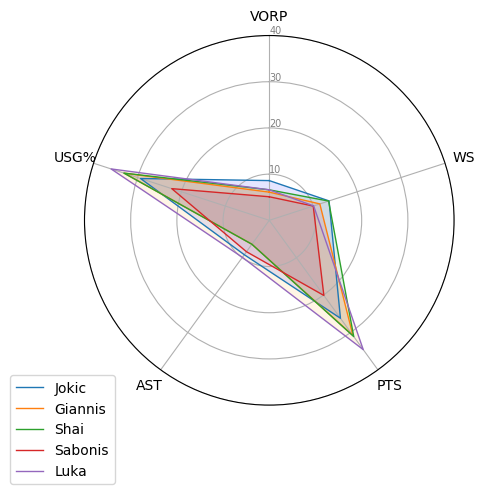

In [28]:
from math import pi
 
# Set data
df = pd.DataFrame({
'Player': MVP_Player_Comparison['Player'].tolist(),
'VORP': MVP_Player_Comparison['VORP'].tolist(), #VORP
'DWS': MVP_Player_Comparison['WS'].tolist(), #WS
'BLK': MVP_Player_Comparison['PTS'].tolist(), #PTS
'WS': MVP_Player_Comparison['AST'].tolist(), #AST
'DRB': MVP_Player_Comparison['USG%'].tolist(), #USG%
})
 
# ------- PART 1: Create background
 
# number of variable
categories= ['VORP','WS','PTS','AST','USG%']
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30,40], ["10","20","30","40"], color="grey", size=7)
plt.ylim(0,40)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('Player').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Jokic")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('Player').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Giannis")
ax.fill(angles, values, 'r', alpha=0.1)

# Ind3
values=df.loc[2].drop('Player').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Shai")
ax.fill(angles, values, 'g', alpha=0.1)

# Ind4
values=df.loc[3].drop('Player').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Sabonis")
ax.fill(angles, values, 'purple', alpha=0.1)

# Ind5
values=df.loc[4].drop('Player').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Luka")
ax.fill(angles, values, 'orange', alpha=0.1)

 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

If Im being honest, I robbed the above code from https://python-graph-gallery.com/391-radar-chart-with-several-individuals/ . However, as the data is so similarly distributed, it doesn't actually tell us anything. 

In [29]:
#Top 5
top5_list = ['Nikola Jokić','Giannis Antetokounmpo','Shai Gilgeous-Alexander','Domantas Sabonis','Luka Dončić']
Top_5 = pd.DataFrame()
for i in top5_list:
    Top_5 = pd.concat([Current_Season.loc[Current_Season['Player'] == i],Top_5], axis = 0)
Top_5 = Top_5[['Player','VORP','WS','PTS','AST','USG%']]
Top_5

,Player,VORP,WS,PTS,AST,USG%
162,Luka Dončić,6.6,10.1,34.6,9.9,36.0
546,Domantas Sabonis,5.1,10.0,20.1,8.4,22.2
219,Shai Gilgeous-Alexander,6.6,13.5,31.1,6.4,33.1
13,Giannis Antetokounmpo,6.1,11.5,30.8,6.4,33.0
319,Nikola Jokić,8.6,13.6,26.2,9.2,29.3


We can see from the above DataFrame, that Jokic leads the pack in both VORP  and WS. This is indicative of a player that far exceeds the player who is rostered to replace him, while also contributing the most wins for his team of the top 5 candidates. 

Doncic on the other hand, while coming 5th in our MVP voting, has an insane PPG average, while also nearly averages double digits for assists also. He also has the highest Usage of any of the MVP's indicating the Mavs would want to get him some help.

Giannis, Shai, and Sabonis while coming 2$^{nd}$, 3$^{rd}$ \& 4$^{th}$ respectively, due not show any peaks to the same extent Jokic and Doncic have currently so far this season.

In [30]:
#To put Jokic's stats in context this season against the rest of the league, this is all while playing as a Center

print('Jokic currently ranks in the ', round(Current_Season.VORP.rank(pct = True)[319],3), ' Percentile for VORP')
print('Jokic currently ranks in the ', round(Current_Season.WS.rank(pct = True)[319],3), ' Percentile for Win Shares')
print('Jokic currently ranks in the ', round(Current_Season.PTS.rank(pct = True)[319],3), ' Percentile for Points')
print('Jokic currently ranks in the ', round(Current_Season.AST.rank(pct = True)[319],3), ' Percentile for Assists')
print('Jokic currently ranks in the ', round(Current_Season.PER.rank(pct = True)[319],3), ' Percentile for Player Efficiency Rating')
print('Jokic currently ranks in the ', round(Current_Season.BLK.rank(pct = True)[319],3), ' Percentile for Blocks')
print('Jokic currently ranks in the ', round(Current_Season.STL.rank(pct = True)[319],3), ' Percentile for Steals')

Jokic currently ranks in the  1.0  Percentile for VORP
Jokic currently ranks in the  1.0  Percentile for Win Shares
Jokic currently ranks in the  0.981  Percentile for Points
Jokic currently ranks in the  0.996  Percentile for Assists
Jokic currently ranks in the  0.993  Percentile for Player Efficiency Rating
Jokic currently ranks in the  0.909  Percentile for Blocks
Jokic currently ranks in the  0.955  Percentile for Steals


Out of interest actually, lets see what the top 3 MVP's were each year, as well as the actual MVP to see if there are any similarities

In [31]:
actualMVP = ['Kevin Durant','Steph Curry','Steph Curry','Russel Westbrook','James Harden','Giannis Atetokounmpo','Giannis Antetokounmpo','Nikola Jokic','Nikola Jokic','Joel Embiid']
MVPs = Current_Season_.iloc[:,np.r_[0,-11:-1]]

Top_Votes = {}
for i in Season_List:
    tmplist = []
    Top_Players_Per_Season = MVPs[MVPs[i] == max(MVPs[i])]['Player']
    for j in Top_Players_Per_Season:
        tmplist.append(j)
    Top_Votes[i] = tmplist
#Creating a DataFrame from a dictionary of unequal lengths 
Top_Votes = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in Top_Votes.items()]))
Top_Votes.index = Top_Votes.index + 1
Top_Votes.loc[0] = actualMVP
Top_Votes = Top_Votes.sort_index()
Top_Votes.index = ['Actual MVP Winner'] + ['Joint MVP Winner'for _ in range(Top_Votes.shape[0] - 1)]
Top_Votes.head(4)

,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021,2021-2022,2022-2023
Actual MVP Winner,Kevin Durant,Steph Curry,Steph Curry,Russel Westbrook,James Harden,Giannis Atetokounmpo,Giannis Antetokounmpo,Nikola Jokic,Nikola Jokic,Joel Embiid
Joint MVP Winner,Giannis Antetokounmpo,Izaiah Brockington,Giannis Antetokounmpo,Giannis Antetokounmpo,Giannis Antetokounmpo,Giannis Antetokounmpo,Izaiah Brockington,Giannis Antetokounmpo,Giannis Antetokounmpo,Giannis Antetokounmpo
Joint MVP Winner,Anthony Davis,Trey Jemison,Jalen Brunson,LaMelo Ball,Anthony Davis,Anthony Davis,NaN,Luka Dončić,Jalen Brunson,Luka Dončić
Joint MVP Winner,Shai Gilgeous-Alexander,Jason Preston,Anthony Davis,Paolo Banchero,Luka Dončić,Luka Dončić,NaN,Joel Embiid,Anthony Davis,Shai Gilgeous-Alexander


This folks is why you use ensemble methods and averaging. This is a lot of players. Adding a series of weak learners together to make a strong learner is common practise in ML, and above we can see why. Although there were several winners each year, ensembling all totals together gave us one clear winner. 

# Most Improved Player

OK, for this section, we are going to take a more simplistic approach. 

My thinking is that if a player imporves, statistically from one season to the next, their stats should increase (or decrease in the case of turnovers). Groundbreaking. If a player improves more than another player, this player should have a larger difference in stats from last season. Therefore, the Most Improved Player should have the largest difference in stats from last season. This is the principle we will follow. 

What is the plan. 

**1** Reduce the dataset down to only players that appeared in both 2022-2023, and 2023-2024. 

**2** After some investigation, I've noticed that certain players have multiple entries due to playing in multiple teams and positions. If a player has multiple statlines, Basketball Reference has a handy feature where an extra row is added, with the players average for that season for all teams. This is the row we will use per player. A function will need to be defined that reduces the dataset even further to only one column per player per season. 



In [55]:
#Selecting data from the DB only corresponding to the last 2 seasons using the already established SQL coneection
This_Season = pd.read_sql("SELECT * FROM NBA_Player_Data WHERE Season = '2023-2024'", conn)
Last_Season = pd.read_sql("SELECT * FROM NBA_Player_Data WHERE Season = '2022-2023'", conn)

This_Season[This_Season['Player'] == 'Mike Muscala']

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
449,449,358,Mike Muscala,C,32,TOT,40,6,13.2,1.3,...,-0.2,0.2,0.1,0.006,-3.7,-1.5,-5.2,-0.4,2023-2024,0
450,450,358,Mike Muscala,C,32,WAS,24,2,14.1,1.4,...,-0.2,0.1,0.0,-0.006,-4.5,-1.8,-6.3,-0.4,2023-2024,0
451,451,358,Mike Muscala,C,32,DET,13,4,13.2,1.2,...,0.1,0.1,0.2,0.047,-1.6,-0.6,-2.1,0.0,2023-2024,0
452,452,358,Mike Muscala,C,32,OKC,3,0,6.7,0.7,...,-0.1,0.0,-0.1,-0.134,-9.2,-4.3,-13.5,-0.1,2023-2024,0


**3** The entire dataset will need to be normalised. This is to make every feature equivalent. This is due to the magnitude of some features potentially making them much more important to a players improvement than other. For example a player improving their PPG from 11 to 16 will affect their Season difference more than going from 0 to 1 steal a game. 

**4** Finally a function will be written, that calculates a players statistical improvement from last season, and the dataset will be ordered by this column. 

### 1

In [56]:
#Creating a Set of names from each season, this is to remove duplicate names, and also to check for the intersection between both sets. This
#will allow us to merge and concatenate Player data from both season dependant on whether their name is in this intersection set or not
This_Season_Names = set(This_Season['Player'])
Last_Season_Names = set(Last_Season['Player'])
Common_Names = This_Season_Names.intersection(Last_Season_Names)
Common_Names = list(Common_Names)
Merged_Seasons = pd.concat([This_Season[This_Season['Player'].isin(Common_Names)], Last_Season[Last_Season['Player'].isin(Common_Names)]],axis = 0)

In [57]:
Merged_Seasons[Merged_Seasons['Player'] == 'Ivica Zubac']

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
692,692,554,Ivica Zubac,C,26,LAC,52,52,26.2,5.0,...,3.3,1.7,5.1,0.178,0.6,-0.1,0.5,0.9,2023-2024,0
678,678,539,Ivica Zubac,C,25,LAC,76,76,28.6,4.3,...,3.8,2.9,6.7,0.149,-1.1,0.2,-0.9,0.6,2022-2023,0


See above the one player having 2 entries for both seasons

In [58]:
print("We've dropped", len(This_Season) + len(Last_Season) - len(Merged_Seasons), "players")

We've dropped 242 players


We also have a new issue. When both DataFrames are combined, some players will have an identical index in both DF's. See below for an example for Damian Jones. We are therefore going to reset both the 'Index' feature and the actual index to a new number range from 0 to the Merged DF length in order to mitigate any indexing issues that could appear down the line! 

In [59]:
Merged_Seasons[Merged_Seasons['Player'] == 'Damian Jones']

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
321,321,256,Damian Jones,C,28,CLE,29,0,6.8,0.9,...,0.2,0.3,0.6,0.135,-2.6,2.0,-0.6,0.1,2023-2024,0
320,320,251,Damian Jones,C,27,TOT,41,1,11.6,1.3,...,0.7,0.5,1.2,0.119,-2.0,0.3,-1.7,0.0,2022-2023,0
321,321,251,Damian Jones,C,27,LAL,22,1,8.0,0.9,...,0.2,0.3,0.4,0.117,-2.6,0.7,-2.0,0.0,2022-2023,0
322,322,251,Damian Jones,C,27,UTA,19,0,15.8,1.8,...,0.5,0.2,0.8,0.120,-1.7,0.2,-1.5,0.0,2022-2023,0


In [60]:
Merged_Seasons['index'] = [i for i in range(0,len(Merged_Seasons))]
Merged_Seasons.index = Merged_Seasons['index']

In [61]:
Merged_Seasons[Merged_Seasons['Player'] == 'Damian Jones']

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
index,,,,,,,,,,,,,,,,,,,,,
253,253,256,Damian Jones,C,28,CLE,29,0,6.8,0.9,...,0.2,0.3,0.6,0.135,-2.6,2.0,-0.6,0.1,2023-2024,0
826,826,251,Damian Jones,C,27,TOT,41,1,11.6,1.3,...,0.7,0.5,1.2,0.119,-2.0,0.3,-1.7,0.0,2022-2023,0
827,827,251,Damian Jones,C,27,LAL,22,1,8.0,0.9,...,0.2,0.3,0.4,0.117,-2.6,0.7,-2.0,0.0,2022-2023,0
828,828,251,Damian Jones,C,27,UTA,19,0,15.8,1.8,...,0.5,0.2,0.8,0.120,-1.7,0.2,-1.5,0.0,2022-2023,0


### 2


In [62]:
Merged_Seasons.shape

(1130, 54)

In [63]:
Merged_Seasons['Player'].value_counts()

Player
Mike Muscala         7
Patrick Beverley     6
Spencer Dinwiddie    6
Jordan Nwora         6
Kira Lewis Jr.       5
                    ..
Al Horford           2
Jrue Holiday         2
Aaron Holiday        2
Haywood Highsmith    2
Ivica Zubac          2
Name: count, Length: 442, dtype: int64

In [64]:
print('The number of players that changed team or position over the last 2 seasons is', len([i for i in Merged_Seasons['Player'].value_counts() if i > 2]))

The number of players that changed team or position over the last 2 seasons is 117


In [65]:
sum = 0
for i in [j for j in Merged_Seasons['Player'].value_counts() if j > 2] :
    sum+= i
print(f'Corresponding to a total of {sum} entries')

Corresponding to a total of 480 entries


In [66]:
Merged_Seasons[Merged_Seasons['Player'] == 'Patrick Beverley']

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
index,,,,,,,,,,,,,,,,,,,,,
54,54,41,Patrick Beverley,PG,35,TOT,61,6,19.3,2.1,...,0.7,1.2,1.9,0.078,-1.8,0.3,-1.5,0.1,2023-2024,0
55,55,41,Patrick Beverley,PG,35,PHI,47,5,19.6,2.2,...,0.7,0.9,1.5,0.081,-1.5,-0.1,-1.5,0.1,2023-2024,0
56,56,41,Patrick Beverley,PG,35,MIL,14,1,18.6,1.9,...,0.0,0.3,0.4,0.066,-3.1,1.6,-1.5,0.0,2023-2024,0
612,612,39,Patrick Beverley,SG-PG,34,TOT,67,67,27.1,2.1,...,0.8,2.1,3.0,0.079,-2.9,1.7,-1.2,0.3,2022-2023,0
613,613,39,Patrick Beverley,SG,34,LAL,45,45,26.9,2.2,...,0.5,1.3,1.8,0.071,-3.2,1.4,-1.8,0.1,2022-2023,0
614,614,39,Patrick Beverley,PG,34,CHI,22,22,27.5,2.1,...,0.3,0.9,1.2,0.096,-2.4,2.2,-0.2,0.3,2022-2023,0


See the above, Patrick Beverley has 6 rows here, but we only want to keep the two 'TOT' rows, which contain all season averages. This is due to Beverley playing for multiple teams both seasons. However if a player plays for two teams and one the next, we only want one 'TOT' row, and the other row to be the players stats for the team he played for that other season. See below for Damian Jones to illustrate (we only want to keep rows 253 & 826) :

In [67]:
Merged_Seasons[Merged_Seasons['Player'] == 'Damian Jones']

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
index,,,,,,,,,,,,,,,,,,,,,
253,253,256,Damian Jones,C,28,CLE,29,0,6.8,0.9,...,0.2,0.3,0.6,0.135,-2.6,2.0,-0.6,0.1,2023-2024,0
826,826,251,Damian Jones,C,27,TOT,41,1,11.6,1.3,...,0.7,0.5,1.2,0.119,-2.0,0.3,-1.7,0.0,2022-2023,0
827,827,251,Damian Jones,C,27,LAL,22,1,8.0,0.9,...,0.2,0.3,0.4,0.117,-2.6,0.7,-2.0,0.0,2022-2023,0
828,828,251,Damian Jones,C,27,UTA,19,0,15.8,1.8,...,0.5,0.2,0.8,0.120,-1.7,0.2,-1.5,0.0,2022-2023,0


In [68]:
#Getting a list of Players with more than 1 statline per season
Duplicate_Players = []
for i in list(Merged_Seasons['Player']):
    if list(Merged_Seasons['Player']).count(i) > 2:
        Duplicate_Players.append(i)
Duplicate_Players = list(set(Duplicate_Players))
len(Duplicate_Players)

117

In [69]:
#Here we are getting the indexes of the 'TOT' rows, saving them to  list. 'The Drop' list will need to be further split, to keep rows corresponding 
#to full seasons
TOT_Keep = []
Non_TOT = []
for i in Duplicate_Players:
    tmp = Merged_Seasons[Merged_Seasons['Player'] == i]
    TOT_Keep.append(tmp[tmp['Tm'] == 'TOT'].index.astype(int))
    Non_TOT.append(tmp[tmp['Tm'] != 'TOT'].index.astype(int))

In [70]:
# We need to do some work on on the the list of indexes to be dropped, as currently it's a list of lists. We'll also convert the items to keep to a  
#list of integers rather than a list Pandas DataFrame indexes
TOT_Keep = [ item for sublist in TOT_Keep for item in sublist]
Non_TOT = [item for sublist in Non_TOT for item in sublist]
print(f'{len(TOT_Keep)} rows to be kept, while {len(Non_TOT)} to be further split')

121 rows to be kept, while 359 to be further split


In [71]:
len(TOT_Keep)

121

We now have the indexes, of the 'Non-TOT' rows, for players who played in multiple teams/positions over the last two seasons. We now need to isolate the rows which correspond to full seasons. If we examine what we now have for a single player:

In [72]:
Merged_Seasons.loc[Non_TOT[:3]]

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
index,,,,,,,,,,,,,,,,,,,,,
366,366,358,Mike Muscala,C,32,WAS,24,2,14.1,1.4,...,-0.2,0.1,0.0,-0.006,-4.5,-1.8,-6.3,-0.4,2023-2024,0
367,367,358,Mike Muscala,C,32,DET,13,4,13.2,1.2,...,0.1,0.1,0.2,0.047,-1.6,-0.6,-2.1,0.0,2023-2024,0
368,368,358,Mike Muscala,C,32,OKC,3,0,6.7,0.7,...,-0.1,0.0,-0.1,-0.134,-9.2,-4.3,-13.5,-0.1,2023-2024,0


What we want is to keep row 253 for Damian Jones and remove the other 2 rows, as based on the Season column these values are his season averages for 2023-2024. This then needs to be done for every player. See the first line printed in the below code as a check. 

In [73]:
#Creating a Dataframe to work with 
Non_TOT_DF = Merged_Seasons.loc[Non_TOT]

#Getting a set of the DataFrame names to iterate through
Names = set(Non_TOT_DF['Player'].tolist())

#Declaring a list to hold the required indexes
Transferred_Player_Full_Seasons = []

#The below names need to be removed. These are players that played for multiple teams both seasons. Therefore we have already removed both of their 
#'TOT' rows. They will also affect the below 
Names_to_Remove = ['Mike Muscala','Patrick Beverley','Spencer Dinwiddie','Jordan Nwora']
for removable in Names_to_Remove:
    Names.remove(removable) 

#Iterating through the names
for i in Names:
    #Declaring a temporary DataFrame
    tmp = Non_TOT_DF[Non_TOT_DF['Player'] == i]
    
    #Getting the unique season, which corresponds to that players full season. As there are only 2 possibilities and value counts works in descending
    #order, the unique value will always be at position 1 
    Season_Values = tmp['Season'].value_counts()
    Unique_Season = Season_Values[Season_Values == 1].index[0]

    #Getting the index that the unique season appears at and keeping it in a list
    Index_to_Remove = tmp[tmp['Season'] == Unique_Season].index
    Transferred_Player_Full_Seasons.append(Index_to_Remove)
    print(i, Index_to_Remove)

T.J. Warren Index([519], dtype='int64', name='index')
OG Anunoby Index([580], dtype='int64', name='index')
Cam Reddish Index([426], dtype='int64', name='index')
Saben Lee Index([278], dtype='int64', name='index')
Keita Bates-Diop Index([601], dtype='int64', name='index')
Gordon Hayward Index([782], dtype='int64', name='index')
Monte Morris Index([929], dtype='int64', name='index')
Cameron Johnson Index([247], dtype='int64', name='index')
Kyrie Irving Index([237], dtype='int64', name='index')
Mike Conley Index([110], dtype='int64', name='index')
Danny Green Index([187], dtype='int64', name='index')
Buddy Hield Index([784], dtype='int64', name='index')
Kyle Lowry Index([876], dtype='int64', name='index')
Bismack Biyombo Index([621], dtype='int64', name='index')
Royce O'Neale Index([952], dtype='int64', name='index')
Garrison Mathews Index([316], dtype='int64', name='index')
Mo Bamba Index([28], dtype='int64', name='index')
David Roddy Index([1008], dtype='int64', name='index')
Yuta Watan

Now finally, we'll add the indexes of:

**A:** The players who only appear once in each season.

**B:** The 'TOT' values for players who changed teams over the last two seasons, as these rows account for average stats between 2 teams. 

**C:** The Season averages for players who transferred once over the last two seasons, for the season in which they didn't transfer. 

In [74]:
#Getting a list of Players with only 1 statline per season
Non_Duplicate_Players = []
for i in list(Merged_Seasons['Player']):
    #The count is set to 3 below as non-Transferred players will have 2 rows (One for each Season)
    if list(Merged_Seasons['Player']).count(i) < 3 :
        Non_Duplicate_Players.append(i)
Non_Duplicate_Players = list(set(Non_Duplicate_Players))

In [75]:
Non_Duplicate_Player_Index = []
for i in Non_Duplicate_Players:
    tmp = Merged_Seasons[Merged_Seasons['Player'] == i ]
    Non_Duplicate_Player_Index.append(tmp.index)
#As each player has 2 rows, this list of list needs explansion again 
Non_Duplicate_Player_Index = [item for sublist in Non_Duplicate_Player_Index for item in sublist]

In [76]:
#Adding up the lists
All_Indexes = TOT_Keep + Non_Duplicate_Player_Index + Transferred_Player_Full_Seasons
len(All_Indexes)

884

In [77]:
len(Merged_Seasons['Player'].value_counts())

442

Now to do some maths to check the above figure. Our Merged Dataframe had initially 1130 rows. These rows had players with multiple seasons, and multiple teams/positions. 

Our Value_Counts() method above applied to the Player column of the Merged Data tells us that we have 442 Players in it that have played in both of the last two seasons. Each player has a row per season, so therefore 442 * 2 matches our Index list length! 

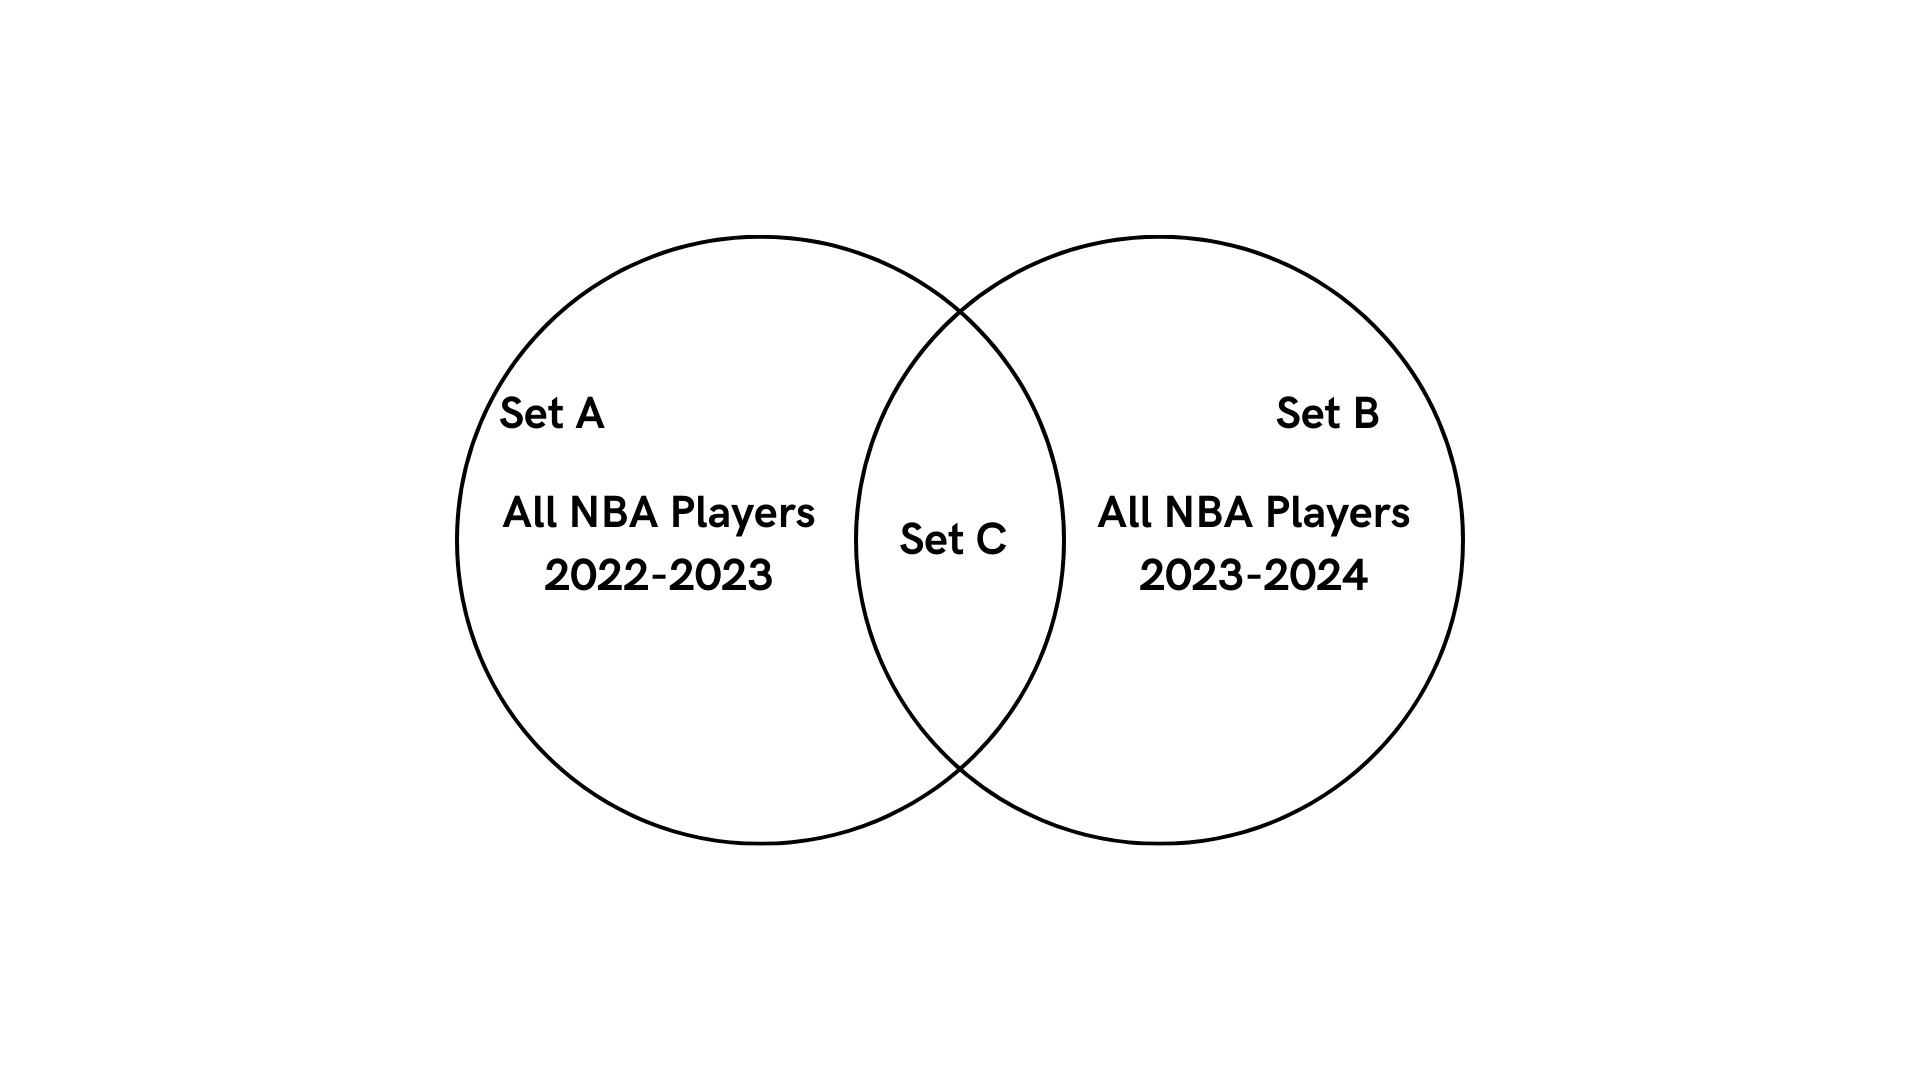

In [78]:
from IPython.display import display
from PIL import Image
path="C:/Users/conor/Documents/Python/NBA Player Awards/Section 1 of MIP.png"
display(Image.open(path))

The above Image essentially shows the point of step 1 here, to give us Set C, the intersection of Set A and B. 

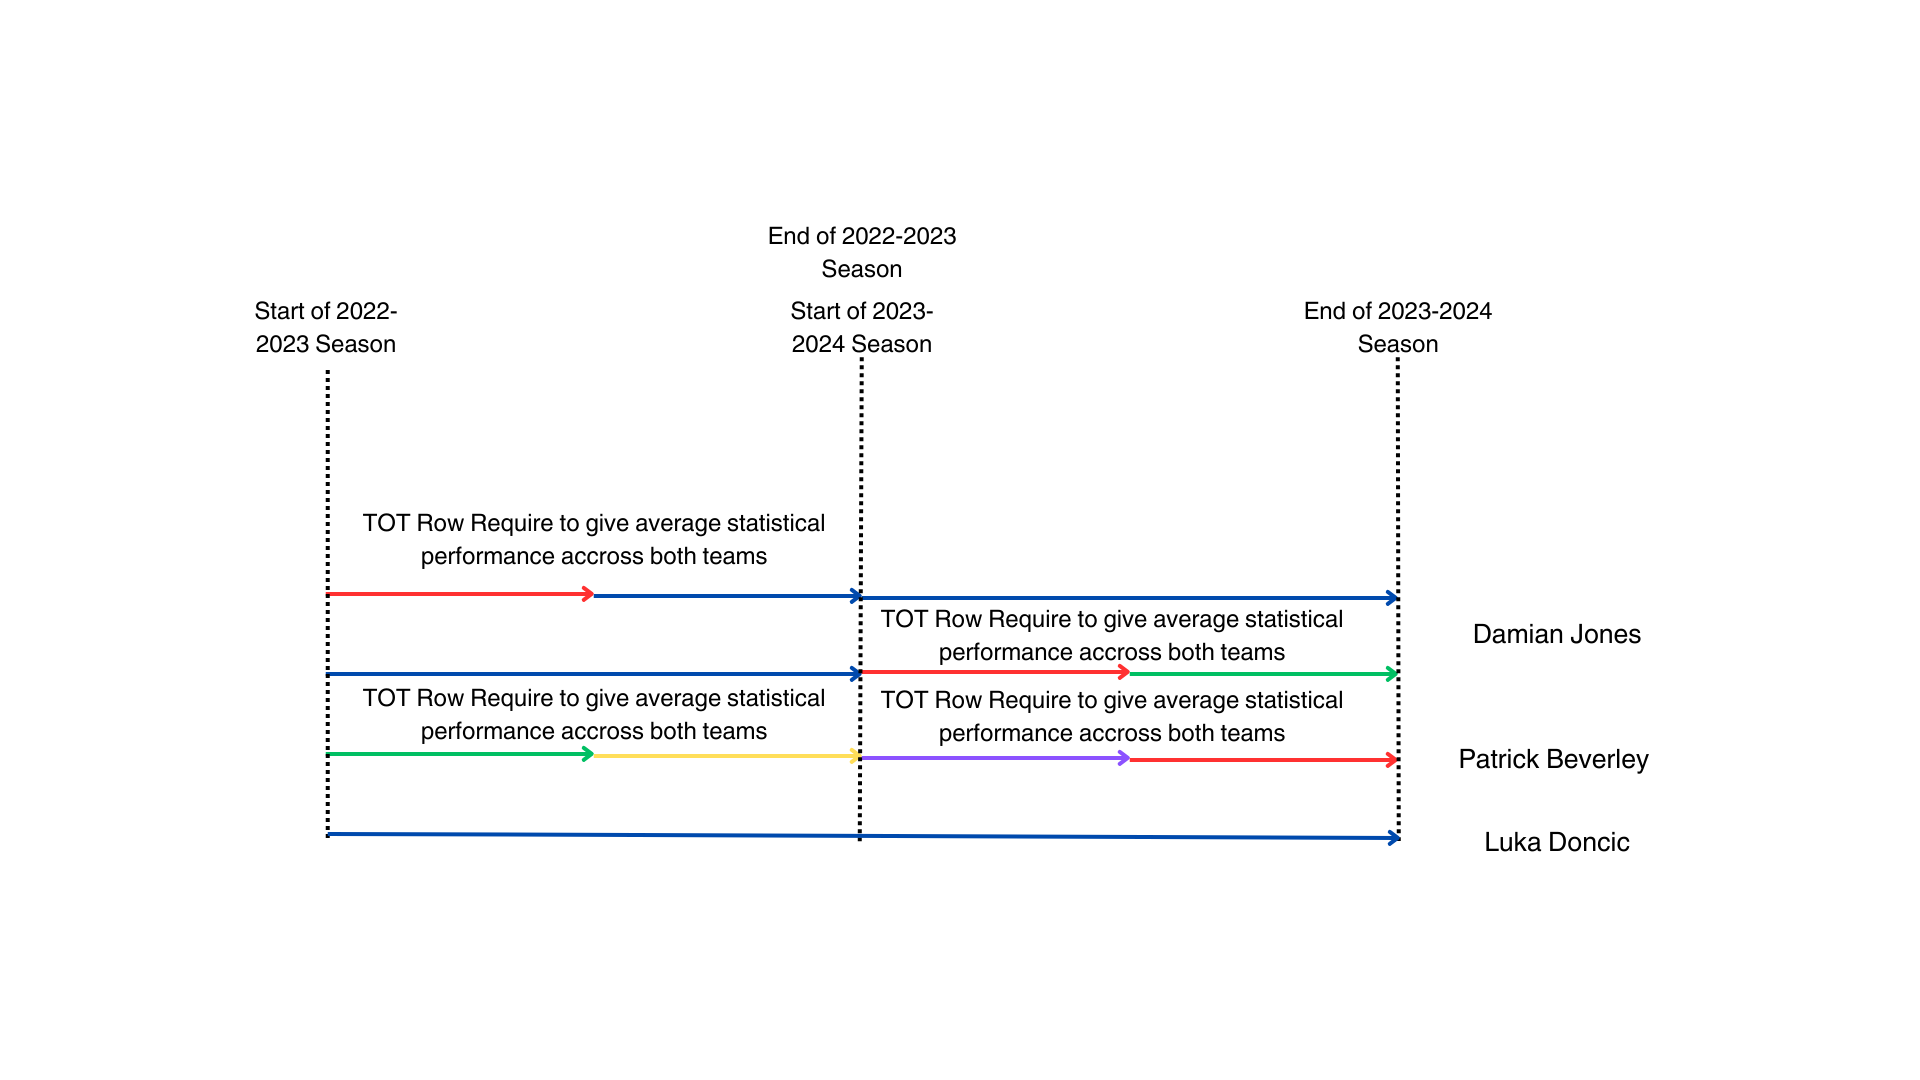

In [79]:
path="C:/Users/conor/Documents/Python/NBA Player Awards/Section 2 of MIP.png"
display(Image.open(path))

The above Image then shows what we had to wrangel with, once we actually had Set C. We had to account for players switching teams and positions etc over the last 2 years, resulting in our need to wrangel the TOT, and specific rows in order to finally get our dataset. 

In [80]:
Merged_Seasons.drop([x for x in list(Merged_Seasons.index) if x not in All_Indexes], inplace = True)

In [81]:
Merged_Seasons.shape

(884, 54)

In [82]:
Merged_Seasons

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
index,,,,,,,,,,,,,,,,,,,,,
0,0,1,Precious Achiuwa,PF-C,24,TOT,58,18,23.0,3.5,...,0.9,1.8,2.8,0.100,-1.7,0.4,-1.3,0.2,2023-2024,0
3,3,2,Bam Adebayo,C,26,MIA,54,54,34.6,7.6,...,1.8,3.1,4.9,0.125,0.2,1.3,1.5,1.7,2023-2024,0
4,4,3,Ochai Agbaji,SG,23,TOT,64,15,19.3,2.1,...,-0.2,0.5,0.3,0.012,-3.2,-0.7,-3.9,-0.6,2023-2024,0
7,7,4,Santi Aldama,PF,23,MEM,54,28,25.8,4.0,...,-0.1,1.8,1.7,0.059,-1.0,0.4,-0.6,0.5,2023-2024,0
8,8,5,Nickeil Alexander-Walker,SG,25,MIN,66,18,23.4,2.8,...,1.1,2.4,3.5,0.109,-1.2,1.6,0.4,0.9,2023-2024,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,1125,535,Thaddeus Young,PF,34,TOR,54,9,14.7,2.0,...,0.7,1.1,1.8,0.109,-1.8,1.9,0.1,0.4,2022-2023,0
1126,1126,536,Trae Young,PG,24,ATL,73,73,34.8,8.2,...,5.3,1.4,6.7,0.126,5.3,-2.0,3.3,3.4,2022-2023,0
1127,1127,537,Omer Yurtseven,C,24,MIA,9,0,9.2,1.8,...,0.2,0.1,0.3,0.159,-2.5,-1.5,-3.9,0.0,2022-2023,0


### 3

For this Analysis, we are also only going to include players who played more than or equal to the the minimum Minutes oer Game of any of the last 5 MIP winners to remove players who maybe had an impactful few minutes at the end of a game which could potentially inflate their scores.

In [83]:
Winner2023 = pd.read_sql("""SELECT MP FROM NBA_Player_Data WHERE Player = 'Lauri Markkanen' AND Season = '2022-2023'""", conn)
Winner2022 = pd.read_sql("""SELECT MP FROM NBA_Player_Data WHERE Player = 'Ja Morant' AND Season = '2021-2022'""", conn)
Winner2021 = pd.read_sql("""SELECT MP FROM NBA_Player_Data WHERE Player = 'Julius Randle' AND Season = '2020-2021'""", conn)
Winner2020 = pd.read_sql("""SELECT MP FROM NBA_Player_Data WHERE Player = 'Brandon Ingram' AND Season = '2019-2020'""", conn)
Winner2019 = pd.read_sql("""SELECT MP FROM NBA_Player_Data WHERE Player = 'Pascal Siakam' AND Season = '2018-2019'""", conn)
MIP_MP_Min = pd.concat([Winner2023,Winner2022,Winner2021,Winner2020,Winner2019],axis=0).min()
MIP_MP_Min = float(MIP_MP_Min.iloc[0])
type(MIP_MP_Min)

float

In [84]:
This_Season_Average = mean(Merged_Seasons[Merged_Seasons['Season'] == '2023-2024']['MP'])
Players_to_Consider = list(Merged_Seasons[(Merged_Seasons['Season'] == '2023-2024') & (Merged_Seasons['MP'] > MIP_MP_Min)]['Player'])

In [85]:
print(f'We will only consider {len(Players_to_Consider)} of the total {len(Merged_Seasons)/2} players, as {abs(len(Players_to_Consider) - len(Merged_Seasons)/2)} players did not play enough minutes to warrant an inclusion')

We will only consider 68 of the total 442.0 players, as 374.0 players did not play enough minutes to warrant an inclusion


In [86]:
#Splitting the data into descriptive, and statistically important data
Numerical_Columns_to_Consider = [ 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Categorical_Columns_to_Consider = ['Player', 'Pos', 'Age', 'Tm',  'Season', 'Rookie Season']

# Normalize the subset of columns
Normalised_Columns = scaler.fit_transform(Merged_Seasons[Numerical_Columns_to_Consider])
Merged_Seasons.loc[:,Numerical_Columns_to_Consider] = Normalised_Columns

In [87]:
Merged_Seasons.head(5)

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
index,,,,,,,,,,,,,,,,,,,,,
0,0,1,Precious Achiuwa,PF-C,24,TOT,58,0.216867,0.555556,0.296610,...,0.213740,0.367347,0.266667,0.661301,0.526882,0.355289,0.341689,0.156863,2023-2024,0
3,3,2,Bam Adebayo,C,26,MIA,54,0.650602,0.841975,0.644068,...,0.282443,0.632653,0.393939,0.677399,0.577957,0.373253,0.378628,0.303922,2023-2024,0
4,4,3,Ochai Agbaji,SG,23,TOT,64,0.180723,0.464198,0.177966,...,0.129771,0.102041,0.115152,0.604636,0.486559,0.333333,0.307388,0.078431,2023-2024,0
7,7,4,Santi Aldama,PF,23,MEM,54,0.337349,0.624691,0.338983,...,0.137405,0.367347,0.200000,0.634900,0.545699,0.355289,0.350923,0.186275,2023-2024,0
8,8,5,Nickeil Alexander-Walker,SG,25,MIN,66,0.216867,0.565432,0.237288,...,0.229008,0.489796,0.309091,0.667096,0.540323,0.379242,0.364116,0.225490,2023-2024,0


### 4

In [88]:
#Creating a function that calculates a players improvement from last season
def Calculate_Player_Improvement(Player):
    #Only taking the numerical data from this and last season
    This_Season = Merged_Seasons[(Merged_Seasons['Player'] == Player) & (Merged_Seasons['Season'] == '2023-2024')]
    This_Season = This_Season[Numerical_Columns_to_Consider]
    Last_Season = Merged_Seasons[(Merged_Seasons['Player'] == Player) & (Merged_Seasons['Season'] == '2022-2023')]
    Last_Season = Last_Season[Numerical_Columns_to_Consider]

    #Lashing it into a dataframe, and being sure to subtract last seasons values from this season. This ensures that the largest positive difference
    #means the biggest improvement. 
    Combined_Seasons = pd.concat([Last_Season, This_Season], axis = 0)
    Difference = Combined_Seasons.iloc[1] - Combined_Seasons.iloc[0]
    #Here, as you want a player to commit less Personal Fouls and Turnovers we subtract them from the sum. We have to times this by two, as the sum 
    #function has already added them in!
    return (Difference.sum() - 2*(Difference['TOV'] + Difference['PF']))

In [89]:
#Declaring Dicts and Lists
Player_Improvement = {}
Improvement_Scores= []

#Applying the function to players who played enough minutes
for i in Players_to_Consider:
    Improvement_Scores.append(Calculate_Player_Improvement(i))

Player_Improvement = { 'Player' : Players_to_Consider, 'Improvement Score' : Improvement_Scores}
Player_Improvement = pd.DataFrame(Player_Improvement)
Player_Improvement.head(5)

,Player,Improvement Score
0,Bam Adebayo,-0.298234
1,Grayson Allen,0.954673
2,Giannis Antetokounmpo,0.517377
3,OG Anunoby,-1.393801
4,LaMelo Ball,-0.360757


In [90]:
#Showing the players who have improved the most this season
Player_Improvement.sort_values(by=['Improvement Score'], ascending= False)[:16]

,Player,Improvement Score
38,Jalen Johnson,4.516239
65,Coby White,3.786916
45,Tyrese Maxey,2.723832
53,Alperen Sengun,2.347475
7,Scottie Barnes,2.255784
54,Shaedon Sharpe,2.116495
60,Karl-Anthony Towns,1.597719
5,Paolo Banchero,1.532851
57,Jabari Smith Jr.,1.426563
15,Cade Cunningham,1.396008


In [91]:
MIP_Player = pd.DataFrame()

#Comparing Jalen Johnsons stats from last season to this season
J_Johnson_Last_Season = pd.read_sql("SELECT * FROM NBA_Player_Data WHERE Season = '2023-2024' AND Player = 'Jalen Johnson'", conn) 
J_Johnson_This_Season =  pd.read_sql("SELECT * FROM NBA_Player_Data WHERE Season = '2023-2024' AND Player = 'Jalen Johnson'", conn)

MIP_Player = pd.concat([J_Johnson_Last_Season, J_Johnson_This_Season], axis = 0)
MIP_Player

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
0,314,249,Jalen Johnson,SF,22,ATL,48,45,34.0,6.3,...,1.9,1.5,3.4,0.1,0.2,0.7,0.9,1.2,2023-2024,0
0,314,249,Jalen Johnson,SF,22,ATL,48,45,34.0,6.3,...,1.9,1.5,3.4,0.1,0.2,0.7,0.9,1.2,2023-2024,0


Just a quick eye-test on our MIP, we can see he has gone from only starting 6 of 70 games, only getting 14.9 minutes oer game to starting 45 of 48 games playing 34 minutes per game.

In [92]:
MIP_Player = pd.DataFrame()

#Comparing Jalen Johnsons stats from last season to this season
J_Johnson_Last_Season = Merged_Seasons[(Merged_Seasons['Player'] == 'Jalen Johnson') & (Merged_Seasons['Season'] == '2022-2023')]
J_Johnson_This_Season =  Merged_Seasons[(Merged_Seasons['Player'] == 'Jalen Johnson') & (Merged_Seasons['Season'] == '2023-2024')]

MIP_Player = pd.concat([J_Johnson_Last_Season, J_Johnson_This_Season], axis = 0)
MIP_Player

,index,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,Rookie Season
index,,,,,,,,,,,,,,,,,,,,,
821,821,244,Jalen Johnson,SF,21,ATL,70,0.072289,0.355556,0.194915,...,0.206107,0.265306,0.224242,0.660657,0.540323,0.377246,0.362797,0.196078,2022-2023,0
248,248,249,Jalen Johnson,SF,22,ATL,48,0.542169,0.827160,0.533898,...,0.290076,0.306122,0.303030,0.661301,0.577957,0.361277,0.370712,0.254902,2023-2024,0


In [93]:
MIP_Player_Values = MIP_Player[[ 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']]
MIP_Player_Difference = MIP_Player_Values.iloc[1] - MIP_Player_Values.iloc[0]
type(MIP_Player_Difference)

pandas.core.series.Series

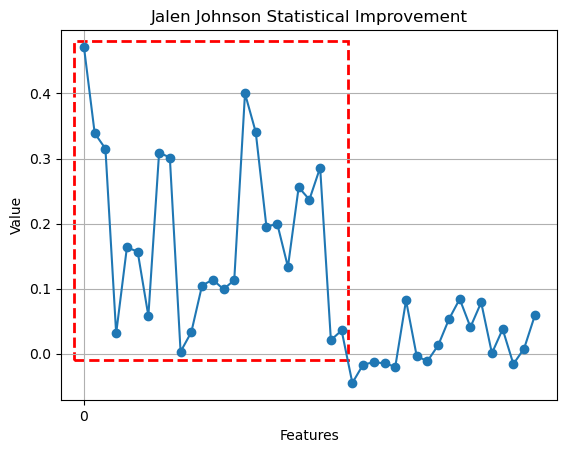

In [94]:

from matplotlib.patches import Rectangle

MIP_Player_Difference = pd.DataFrame(MIP_Player_Difference)
# Plotting
plt.plot(MIP_Player_Difference.index, MIP_Player_Difference.values, marker='o', linestyle='-')
plt.title('Jalen Johnson Statistical Improvement')
plt.xlabel('Features')
plt.ylabel('Value')
plt.xticks(range(len(MIP_Player_Difference.columns)), MIP_Player_Difference.columns)  # Setting x-tick labels to feature names
plt.grid(True)

# Adding a rectangle to the plot to highlight the entire graph
rectangle = Rectangle((-0.9,-0.01), 25.5, 0.49, edgecolor='r', facecolor='none', linewidth = 2, linestyle = '--')
plt.gca().add_patch(rectangle)

plt.show()

We can see that the majority of the statistical improvement in Jalen Johnsons game has come from the first 24 features, these being the features encapsulated within the red rectangle above. A Spider plot of the features can be seen below:

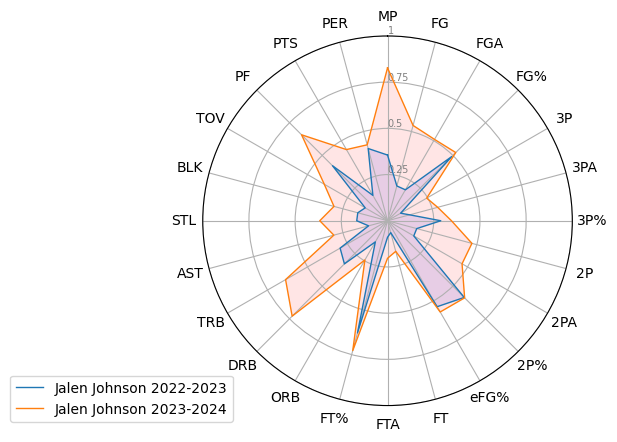

In [95]:

# Set data
df = pd.DataFrame({
'Player': MIP_Player['Player'].tolist(),
'MP': MIP_Player['MP'].tolist(), 
'FG': MIP_Player['FG'].tolist(), 
'FGA': MIP_Player['FGA'].tolist(), 
'FG%': MIP_Player['FG%'].tolist(), 
'3P': MIP_Player['3P'].tolist(), 
'3PA' : MIP_Player['3PA'].tolist(),
'3P%': MIP_Player['3P%'].tolist(),
'2P': MIP_Player['2P'].tolist(), 
'2PA': MIP_Player['2PA'].tolist(), 
'2P%': MIP_Player['2P%'].tolist(), 
'eFG%': MIP_Player['eFG%'].tolist(), 
'FT': MIP_Player['FT'].tolist(), 
'FTA' : MIP_Player['FTA'].tolist(),
'FT%': MIP_Player['FT%'].tolist(),
'ORB': MIP_Player['ORB'].tolist(), 
'DRB': MIP_Player['DRB'].tolist(), 
'TRB': MIP_Player['TRB'].tolist(), 
'AST': MIP_Player['AST'].tolist(), 
'STL': MIP_Player['STL'].tolist(), 
'BLK' : MIP_Player['BLK'].tolist(),
'TOV': MIP_Player['TOV'].tolist(),
'PF': MIP_Player['PF'].tolist(), 
'PTS': MIP_Player['PTS'].tolist(), 
'PER': MIP_Player['PER'].tolist()
})
 
# ------- PART 1: Create background
 
# number of variable
categories= ['MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PER']
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75,1], ["0.25","0.5","0.75","1"], color="grey", size=7)
plt.ylim(0,1)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('Player').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Jalen Johnson 2022-2023")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('Player').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Jalen Johnson 2023-2024")
ax.fill(angles, values, 'r', alpha=0.1)

 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

The above shows the first 24 metrics from the previous line graph. We can see from last season compared to this, that Johnson improved considerably in rebounding, with vast increases in TRB and DRB, while also increasing his Offensive rebounding stats. He also attempts more 2 and 3 Point shots, which has consequently led to him increasing his number of Field Goals. 

A lot of Johnsons improvement this season has come from his move to a Starting Small Forward rather than a substitute. Carpe Diem. 

# Conclusion 

To summarize the work that has been completed here: 

Initially data was obtained from Basketball-Reference.com for each players Season Statistics for each season for the last 10 years. The MVP and DPOY voting for the last 10 years was also obtained. This was all collated into one singular SQL DB stored locally. This was to centralise the data to one location for ease of access. 

The first body of work involved creating several independant Decision Tree Regressors, one per season for the last 10 years. Each tree voted on who the current seasons **MVP** should be, based upon how the MVP Voting share was distributed for that specific season. This then led to 10 different voting distributions, which were then added together (ensembling) to get the player with the most shares in total accross all trees. This Random Forest model predicted that the current Season MVP should be **Nikola Jokic**. A further investigation of his stats in comparison to the top 5 players predicted by the model was undertaken. A comparison with the odds supplied by https://www.sportsbet.com.au/betting/basketball-us/nba-player-awards/nba-regular-season-mvp-2023-24-7428930 on the 22$^{nd}$ of March is shown below:

|Player|MVP Prediction|SportsBet Prediction|Odds|
|------|-----|-----|-----|
|Jokic|1|1|1.11/1|
|Giannis|2|4|46/1|
|Shai|3|2|6/1|
|Sabonis|4|N/A|N/A|
|Doncic|5|3|11/1|
|Tatum|6|5|56/1|
|Davies|7|6|126/1|a | |

So a good prediction all in all. We got 6 of that specific bookmakers top 6 in our top 7 just different order. Same numero uno, swap our 2 and 3 and move Doncic up 2 places and we have the same top 3. Happy out. 

Next in my bag of tricks was to predict the **DPOY**. This used the exact same methodology as the MVP voting. We ended up predicting **Davies** as our winnner. Let's cut to the chase and see how our DPOY compares to the bookies

|Player|DPOY Prediction|SportsBet Prediction|Odds|
|------|-----|-----|-----|
|Anthony Davies|1|5|81/1|
|Jarret Allen|2|3|61/1|
|Chet Holmgreen|3|N/A|N/A|
|Alperen Sengun|4|N/A|N/A|
|Rudy Gobert|5|1|1.14/1|
|Nikola Jokic|6|N/A|N/A|
|Wembanyama|7|2|5.5/1|

This prediction wasn't as good as the MVP vote, but we still had 4 of their top 5 in out top 7. We slightly got Jarret Allen's spot wrong, Anthony Davies and Gobert need a swapping. I'm actually surprised Wembanyama is that high up the the DPOY voting in his Rookie year. We got his spot fairly wrong, but we still had him there to be fair. After some analysis we realised Jokic's inclusion was solely due to Win Share and Value Over Replacement Player being metrics in the model here, both of which he is league leader in. 

Finally, we predicted **Jalen Johnson** as our **MIP**. The bulk of the work in this investigation was the preparation of the dataset. We first had to get data for the last two seasons, which then had to be only players that had played in both seasons. This then had to be further reduced to remove rows that did not correspond to players stats for the entire season. Players transferring mid season led to an excess of columns per player. This dataset analysis is explained in depth in the **Most Improved Player** section of this notebook. We finally reduced this dataset to only include players who had played the same Minutes per game as the minimum amount played by any MIP winner of the last 5 years. 

This was also different to the two previous studies, as instead of using DTC Ensembling methods to make a Forrest, I used my own method. The player with the largest increase in positive stats (so everything except turnovers and personal fouls) is the most improved player. So by normalising every column (to avoid larger quantities distoring things) and summing the increase per stat the most improved players could be identified by our new metric.

|Player|DPOY Prediction|SportsBet Prediction|Odds|
|------|-----|-----|-----|
|Jalen Johnson|1|N/A|N/A|
|Cobey Wright|2|2|2.5/1|
|Tyrese Maxey|3|1|1.25/1|
|Alperen Sengun|4|N/A|N/A|
|Scottie Barnes|5|N/A|N/A|

I was actually pleasantly surprised by this one, as we weren't using a Scikit learn Machine Learning package, just our own reasoning. We didn't actually do too bad, getting 2 of the top 4 predicted by the SportsBetting Bookmaker, and being quite close with our predictions. Getting Cobey Wright in the right spot, while their favourite Tyrese Maxey was only 2 spots off top. 

Very good result in this one if I do say so myself.